In [1]:
# DO NOT EDIT
import logging
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
from tqdm import tqdm
import math
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('scratch_training.log'),
        logging.StreamHandler()
    ]
)


In [3]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 3e-4
WEIGHT_DECAY = 1e-4
CONFIDENCE_THRESHOLD = 0.7 
best_val_acc = 0.0
patience_counter = 0


In [46]:
train_loader

In [4]:

train_dir = r'D:\SEM8Major\Datasets\plantnet_300K\images\train'
test_dir = r'D:\SEM8Major\Datasets\plantnet_300K\images\test'
val_dir = r'D:\SEM8Major\Datasets\plantnet_300K\images\val'

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, train_transforms)
test_dataset = datasets.ImageFolder(test_dir, test_transforms)
val_dataset = datasets.ImageFolder(val_dir, test_transforms)  # Directly load validation data

# Class balancing
class_counts = torch.bincount(torch.tensor(train_dataset.targets))
class_weights = 1. / (class_counts + 1e-4)
samples_weights = class_weights[torch.tensor(train_dataset.targets)]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    pin_memory=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)


In [5]:
class ScratchPredictor(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Initial Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Global Average Pooling instead of AdaptiveAvgPool
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier layers (using a more gradual reduction in units)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the feature map from global avg pooling
            nn.Dropout(0.5),
            nn.Linear(512, 2048),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),
            
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            
            nn.Linear(1024, num_classes)
        )

        # Preprocessing pipeline for input images
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Store class names for later use
        self.class_names = train_dataset.classes

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x



In [6]:
model = ScratchPredictor(num_classes=len(class_counts)).to(device)
optimizer = optim.AdamW(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)


In [7]:
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Label Smoothing Cross Entropy
class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        
    def forward(self, logits, targets):
        n_classes = logits.size(-1)
        log_preds = F.log_softmax(logits, dim=-1)
        loss = -log_preds.mean()
        nll = F.nll_loss(log_preds, targets)
        return (1 - self.smoothing) * nll + self.smoothing * loss

# Combined Loss Class
class CombinedLoss(nn.Module):
    def __init__(self, alpha=None, smoothing=0.1):
        super().__init__()
        self.focal = FocalLoss(alpha=alpha)
        self.label_smooth = LabelSmoothingCE(smoothing)
        
    def forward(self, inputs, targets):
        return 0.5*self.focal(inputs, targets) + 0.5*self.label_smooth(inputs, targets)

# Initialize criterion
criterion = CombinedLoss(alpha=class_weights.to(device))


In [8]:
# Learning rate scheduler
def lr_lambda(current_step):
    warmup_steps = 500
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * (current_step - warmup_steps) / (EPOCHS*len(train_loader) - warmup_steps)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    
    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed sample augmentation
        if np.random.rand() < 0.2:
            lam = np.random.beta(0.4, 0.4)
            index = torch.randperm(inputs.size(0)).to(device)
            mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
            outputs = model(mixed_inputs)
            loss = lam * criterion(outputs, labels) + (1 - lam) * criterion(outputs, labels[index])
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item() * inputs.size(0)
    
    avg_train_loss = train_loss / len(train_dataset)
    train_acc = 100.0 * train_correct / total if total > 0 else 0.0
    avg_val_loss = val_loss / len(val_dataset)
    val_acc = 100.0 * val_correct / len(val_dataset)
    
    logging.info(
        f"Epoch {epoch+1}: "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, 'new_data.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 1: 100%|████████████████████████████████████████████████████████| 3379/3379 [1:14:47<00:00,  1.33s/it, Loss=1.34]
2025-03-27 10:33:58,558 - INFO - Epoch 1: Train Loss: 1.5788 | Train Acc: 19.50% | Val Loss: 1.3171 | Val Acc: 32.46%
Epoch 2: 100%|████████████████████████████████████████████████████████| 3379/3379 [1:08:09<00:00,  1.21s/it, Loss=1.27]
2025-03-27 11:45:20,083 - INFO - Epoch 2: Train Loss: 1.3175 | Train Acc: 35.48% | Val Loss: 1.1253 | Val Acc: 43.82%
Epoch 3: 100%|████████████████████████████████████████████████████████| 3379/3379 [1:10:34<00:00,  1.25s/it, Loss=1.14]
2025-03-27 12:58:59,012 - INFO - Epoch 3: Train Loss: 1.1823 | Train Acc: 44.72% | Val Loss: 1.0440 | Val Acc: 52.13%
Epoch 4: 100%|████████████████████████████████████████████████████████| 3379/3379 [1:08:12<00:00,  1.21s/it, Loss=1.04]
2025-03-27 14:10:34,653 - INFO - Epoch 4: Train Loss: 1.0981 | Train Acc: 50.82% | Val Loss: 0.9404 | Val Acc: 58.60%
Epoch 5: 100%|██████████████████████████████████

In [9]:
# Load best model
model = torch.load('new_data.pth', weights_only=False)
model = model.to(device) 


In [10]:
# Final evaluation with proper metrics
def evaluate_predictor(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return classification_report(
        all_labels,
        all_preds,
        target_names=model.class_names,
        digits=4,
        zero_division=0  # Add this parameter
    )
val_report = evaluate_predictor(model, val_loader)
test_report = evaluate_predictor(model, test_loader)

logging.info("\nValidation Report:\n%s", val_report)
logging.info("\nTest Report:\n%s", test_report)


KeyboardInterrupt: 

In [ ]:
# Export to ONNX
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(
    model,
    dummy_input,
    'new_data.onnx',
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)


In [ ]:
def predict(self, image_tensor):
        """For batch prediction"""
        with torch.no_grad():
            outputs = self.forward(image_tensor)
            probs = F.softmax(outputs, dim=1)
            confidences, class_indices = torch.max(probs, dim=1)
            return confidences, class_indices

    def predict_image(self, image_path):
        """For single image prediction"""
        image = Image.open(image_path).convert('RGB')
        tensor = self.preprocess(image).unsqueeze(0).to(device)
        confidence, class_idx = self.predict(tensor)
        
        result = {
            'confidence': confidence.item(),
            'class_index': class_idx.item(),
            'class_name': self.class_names[class_idx.item()]
        }
        
        if result['confidence'] < CONFIDENCE_THRESHOLD:
            result['class_name'] = 'unknown'
            result['class_index'] = -1
            
        return result
        

In [13]:

# Example usage
sample_image_path = r"D:\SEM8Major\Datasets\testimage.jpg"
prediction = model.predict_image(sample_image_path)
print(f"\nPrediction Result for {sample_image_path}:")
print(f"Class: {prediction['class_name']}")
print(f"Confidence: {prediction['confidence']:.2%}")
print(f"Class Index: {prediction['class_index']}")

# Save class names
with open('class_names.txt', 'w') as f:
    f.write('\n'.join(model.class_names))
    

AttributeError: 'ScratchPredictor' object has no attribute 'predict_image'

Classification Report:
                     precision    recall  f1-score   support

     Annual Mercury       0.94      0.75      0.84       154
        Blue Lupine       0.79      0.90      0.84       281
Brazilian Dayflower       0.54      0.64      0.58       131
     Canada Thistle       0.84      0.73      0.78       428
             Carrot       0.89      0.81      0.85       902
         Corn Poppy       0.85      0.77      0.81       502
     Creeping Jenny       0.96      0.94      0.95       338
    Flamingo Flower       0.78      0.92      0.85       281
     Garlic Mustard       0.97      0.76      0.85       792
          Hollyhock       0.94      0.71      0.81       536
               Hops       0.82      0.73      0.77       252
           Lavender       0.70      0.87      0.77       342
          Male Fern       0.70      0.84      0.76       130
           Marigold       0.93      0.87      0.90       897
             Mimosa       0.69      0.82      0.75       128


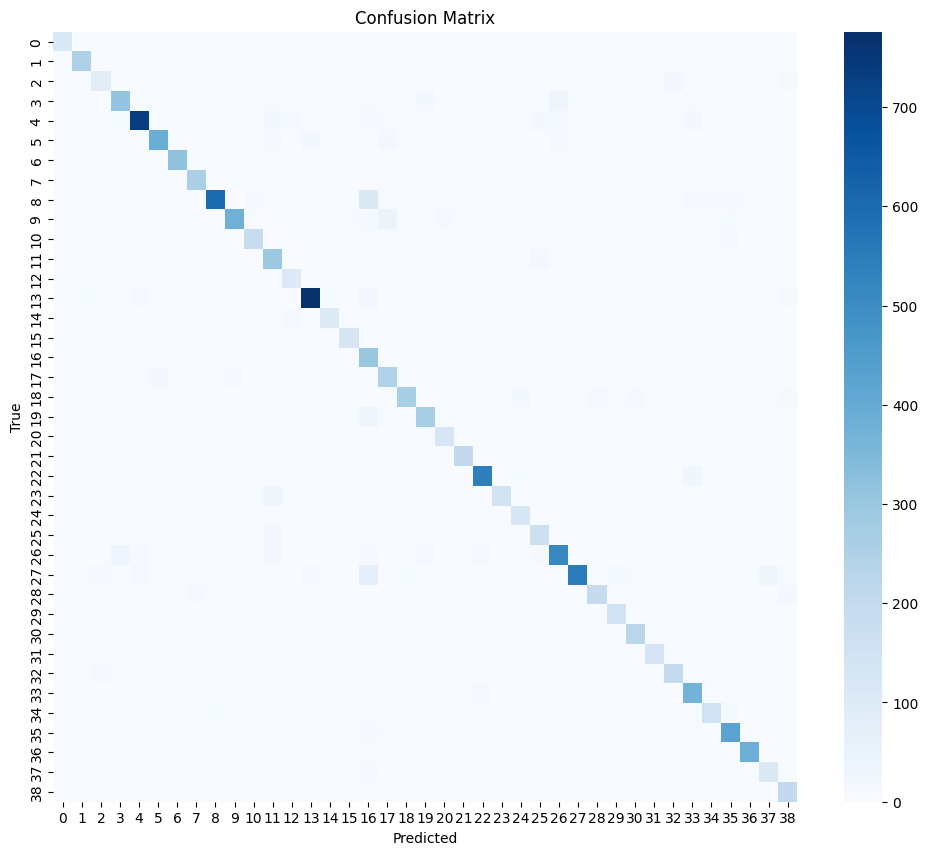

In [12]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ====== Hyperparameters ======
BATCH_SIZE = 32  # or the batch size you used
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====== Define the model again ======
num_classes = len(test_dataset.classes)  # Use your test dataset
# Load best model
model = torch.load('new_data.pth', weights_only=False)
model = model.to(device) 

model.eval()

# ====== Evaluation on Test Loader ======
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ====== Generate Classification Report ======
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# ====== (Optional) Confusion Matrix ======
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
from PIL import Image
import torch
from torchvision import transforms

def predict_image(model, image_path, device):
    # Preprocess (use the same as model.preprocess)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load & preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = model.class_names[predicted.item()]
    
    return predicted_class

# ===== Usage =====
sample_image_path = r"D:\SEM8Major\Datasets\testimage.jpg"
prediction = predict_image(model, sample_image_path, DEVICE)
print(f"Predicted Class: {prediction}")


Predicted Class: Carrot
